In [3]:
import numpy as np 
import pandas as pd
import random

# Load identity and transaction data, only load 10% data due to memory
df_identity = pd.read_csv("../../DataSet/ieee-fraud-detection/train_identity.csv", skiprows=lambda i: i>0 and random.random() > 0.1)
df_transaction = pd.read_csv("../../DataSet/ieee-fraud-detection/train_transaction.csv", skiprows=lambda i: i>0 and random.random() > 0.1)

# Load test data
df_test_identity = pd.read_csv("../../DataSet/ieee-fraud-detection/test_identity.csv", skiprows=lambda i: i>0 and random.random() > 0.1)
df_test_transaction = pd.read_csv("../../DataSet//ieee-fraud-detection/test_transaction.csv", skiprows=lambda i: i>0 and random.random() > 0.1)

In [4]:
# Merge on TransactionID (if desired)
train_data = df_identity.merge(df_transaction, on="TransactionID", how="left")

# Merge on TransactionID (if desired)
test_data = df_test_transaction.merge(df_test_identity, on="TransactionID", how="left")

In [57]:
#process the null data
# Calculate the percentage of null values in each column
null_percentage_train = (train_data.isnull().mean()) * 100

# Display the percentage of null values in each column
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Percentage of null values in each column:")
    print(null_percentage_train)

# Get the counts of NaN values in train_data
train_nan_counts = train_data.isna().sum()
print("NaN values in train_data:")
print(train_nan_counts)

# Drop columns with more than 80% null values
columns_to_drop = null_percentage_train[null_percentage_train > 80].index
cleaned_train = train_data.drop(columns=columns_to_drop)
cleaned_valid = test_data.drop(columns=columns_to_drop)

Percentage of null values in each column:
TransactionID       0.0
id_01               0.0
id_02               0.0
id_03               0.0
id_04               0.0
id_05               0.0
id_06               0.0
id_07               0.0
id_08               0.0
id_09               0.0
id_10               0.0
id_11               0.0
id_12               0.0
id_13               0.0
id_14               0.0
id_15               0.0
id_16               0.0
id_17               0.0
id_18               0.0
id_19               0.0
id_20               0.0
id_21               0.0
id_22               0.0
id_23               0.0
id_24               0.0
id_25               0.0
id_26               0.0
id_27               0.0
id_28               0.0
id_29               0.0
id_30               0.0
id_31               0.0
id_32               0.0
id_33               0.0
id_34               0.0
id_35               0.0
id_36               0.0
id_37               0.0
id_38               0.0
DeviceType          0.

In [58]:
# feature engineering
from sklearn.preprocessing import LabelEncoder
def fill_num_cal_nan(data):
    # Identify numerical columns
    numerical_columns = data.select_dtypes(include=['number']).columns
    
    # Fill NaN values for numerical columns with the mean of each column
    data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())
    # Identify categorical columns
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    # Fill NaN values for categorical columns with a placeholder value, such as 'unknown'
    data[categorical_columns] = data[categorical_columns].fillna('unknown')
    
    # Convert categorical values to numerical using Label Encoding
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        data[col] = label_encoder.fit_transform(data[col])
    
    return data

# Apply the function to your training and test datasets
train_data_filled = fill_num_cal_nan(cleaned_train)
valid_data_filled = fill_num_cal_nan(cleaned_valid)

In [59]:
train_data_filled.describe()
print(train_data_filled.shape)
print(valid_data_filled.shape)

(14550, 421)
(50738, 420)


In [9]:
# Assuming 'isFraud' is your target variable
target_variable = 'isFraud'
ID = 'TransactionID'

# Undersampling before cross validating (prone to overfit)
X = train_data_filled.drop(columns=[target_variable, ID], axis=1)
y = train_data_filled[target_variable]

# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
#basic model
import lightgbm as lgb     
import warnings    
from sklearn.model_selection import StratifiedKFold, KFold    
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss   

warnings.filterwarnings('ignore')

def cv_model(clf, train_x, train_y, test_x, clf_name):    
    folds = 5    
    seed = 2020    
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)    

    train = np.zeros(train_x.shape[0])    
    test = np.zeros(test_x.shape[0])    

    cv_scores = []    

    for i, (train_index, valid_index) in enumerate(kf.split(train_x), 1):    
        print('************************************ {} ************************************'.format(str(i+1)))    
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y.iloc[train_index], train_x.iloc[valid_index], train_y.iloc[valid_index]    

        if clf_name == "lgb":    
            train_matrix = clf.Dataset(trn_x, label=trn_y)    
            valid_matrix = clf.Dataset(val_x, label=val_y)    

            params = {    
                'boosting_type': 'gbdt',    
                'objective': 'binary',    
                'metric': 'auc',    
                'num_leaves': 33,    
                'max_depth': 6,    
                'min_data_in_leaf':45,    
                'min_child_weight':0.001,    
                'bagging_fraction': 0.9,    
                'feature_fraction': 0.9,    
                'bagging_freq': 10,    
                'min_split_gain': 0.1,    
                'reg_lambda':0.01,    
                'reg_alpha':0.08,    
                'learning_rate': 0.01,    
                'seed': 2020,    
                'nthread': 24,    
                'n_jobs':24,    
                'silent': True,    
                'verbose': -1,  
            }    

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)    
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)    
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)    

            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])    

        if clf_name == "xgb":    
            train_matrix = clf.DMatrix(trn_x , label=trn_y)    
            valid_matrix = clf.DMatrix(val_x , label=val_y)    

            params = {'booster': 'gbtree',    
                      'objective': 'binary:logistic',    
                      'eval_metric': 'auc',    
                      'gamma': 1,    
                      'min_child_weight': 1.5,    
                      'max_depth': 5,    
                      'lambda': 10,    
                      'subsample': 0.7,    
                      'colsample_bytree': 0.7,    
                      'colsample_bylevel': 0.7,    
                      'eta': 0.04,    
                      'tree_method': 'exact',    
                      'seed': 2020,    
                      'nthread': 36,    
                      "silent": True,    
                      }    

            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]    

            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)    
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)    
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)    

        if clf_name == "cat":    
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',    
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}    

            model = clf(iterations=20000, **params)    
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),    
                      cat_features=[], use_best_model=True, verbose=500)    

            val_pred  = model.predict(val_x)    
            test_pred = model.predict(test_x)    

        train[valid_index] = val_pred    
        test = test_pred / kf.n_splits    
        cv_scores.append(roc_auc_score(val_y, val_pred))    

        print(cv_scores)    

    print("%s_scotrainre_list:" % clf_name, cv_scores)    
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))    
    print("%s_score_std:" % clf_name, np.std(cv_scores))    
    return train, test

def lgb_model(x_train, y_train, x_test):    
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")    
    return lgb_train, lgb_test   

lgb_train, lgb_test = lgb_model(X_train, y_train, X_test)

************************************ 2 ************************************
[LightGBM] [Warning] num_threads is set with nthread=24, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent


D:\software\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1487: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999889	valid_1's auc: 0.991833
Early stopping, best iteration is:
[152]	training's auc: 0.999804	valid_1's auc: 0.992548
[0.9925476603119584]
************************************ 3 ************************************
[LightGBM] [Warning] num_threads is set with nthread=24, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent


D:\software\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1487: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999922	valid_1's auc: 0.992318
[400]	training's auc: 0.999996	valid_1's auc: 0.993276
[600]	training's auc: 1	valid_1's auc: 0.993754
[800]	training's auc: 1	valid_1's auc: 0.993846
[1000]	training's auc: 1	valid_1's auc: 0.994051
Early stopping, best iteration is:
[998]	training's auc: 1	valid_1's auc: 0.994074
[0.9925476603119584, 0.9940735337694605]
************************************ 4 ************************************
[LightGBM] [Warning] num_threads is set with nthread=24, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent


D:\software\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1487: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999905	valid_1's auc: 0.995213
Early stopping, best iteration is:
[19]	training's auc: 0.996897	valid_1's auc: 0.995578
[0.9925476603119584, 0.9940735337694605, 0.9955779444279821]
************************************ 5 ************************************
[LightGBM] [Warning] num_threads is set with nthread=24, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent


D:\software\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1487: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999812	valid_1's auc: 0.992782
[400]	training's auc: 0.999992	valid_1's auc: 0.993323
[600]	training's auc: 1	valid_1's auc: 0.993539
[800]	training's auc: 1	valid_1's auc: 0.993891
Early stopping, best iteration is:
[734]	training's auc: 1	valid_1's auc: 0.994107
[0.9925476603119584, 0.9940735337694605, 0.9955779444279821, 0.9941068339100347]
************************************ 6 ************************************
[LightGBM] [Warning] num_threads is set with nthread=24, will be overridden by n_jobs=24. Current value: num_threads=24
[LightGBM] [Warning] Unknown parameter: silent


D:\software\anaconda\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
D:\software\anaconda\lib\site-packages\lightgbm\basic.py:1487: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.999865	valid_1's auc: 0.993823
Early stopping, best iteration is:
[111]	training's auc: 0.999573	valid_1's auc: 0.994005
[0.9925476603119584, 0.9940735337694605, 0.9955779444279821, 0.9941068339100347, 0.9940051514668005]
lgb_scotrainre_list: [0.9925476603119584, 0.9940735337694605, 0.9955779444279821, 0.9941068339100347, 0.9940051514668005]
lgb_score_mean: 0.9940622247772473
lgb_score_std: 0.0009588208184992351


In [21]:
#gridsearch，basic model is lightgbm
from sklearn.model_selection import GridSearchCV    

def get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=31, max_depth=-1, bagging_fraction=1.0,    
                       feature_fraction=1.0, bagging_freq=0, min_data_in_leaf=20, min_child_weight=0.001,    
                       min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=None,
                      X_train=X_train, y_train=y_train):    
    # set kfold as 5   
    cv_fold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True, )    

    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,    
                                   n_estimators=n_estimators,    
                                   num_leaves=num_leaves,    
                                   max_depth=max_depth,    
                                   bagging_fraction=bagging_fraction,    
                                   feature_fraction=feature_fraction,    
                                   bagging_freq=bagging_freq,    
                                   min_data_in_leaf=min_data_in_leaf,    
                                   min_child_weight=min_child_weight,    
                                   min_split_gain=min_split_gain,    
                                   reg_lambda=reg_lambda,    
                                   reg_alpha=reg_alpha,    
                                   n_jobs= 8    
                                  )    
    grid_search = GridSearchCV(estimator=model_lgb,    
                               cv=cv_fold,    
                               param_grid=param_grid,    
                               scoring='roc_auc'    
                              )    
    grid_search.fit(X_train, y_train)    

    print('best params of model are:{}'.format(grid_search.best_params_))    
    print('best socre of model is:{}'.format(grid_search.best_score_))

In [24]:
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')
"""set n_estimators as 581，adjust num_leaves and max_depth"""    
lgb_params = {'num_leaves': range(10, 80, 5), 'max_depth': range(3,10,2)}    
get_best_cv_params(learning_rate=0.1, n_estimators=581, num_leaves=None, max_depth=None, min_data_in_leaf=20,    
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0,    
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)  

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsampl

In [25]:
%%capture
import warnings

def custom_lightgbm_warning_filter(message, category, filename, lineno, file=None, line=None):
    if category == UserWarning and "feature_fraction is set=" in str(message):
        return False
    return True

warnings.showwarning = custom_lightgbm_warning_filter

In [26]:
lgb_params = {'num_leaves': range(15, 25, 1), 'max_depth': range(7,11,1)}    
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=None, max_depth=None, min_data_in_leaf=20,    
                   min_child_weight=0.001,bagging_fraction=1.0, feature_fraction=1.0, bagging_freq=0,    
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params)    

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsampl

In [30]:
"""    
set num_leaves=15, max_depth=10    
"""
# adjust bagging_fraction、feature_fraction and bagging_freq
lgb_params = {'bagging_fraction': [i/10 for i in range(5,10,1)],    
              'feature_fraction': [i/10 for i in range(5,10,1)],    
              'bagging_freq': range(0,81,10)    
             }    
get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=15, max_depth=10, min_data_in_leaf=45,    
                   min_child_weight=0.001,bagging_fraction=None, feature_fraction=None, bagging_freq=None,    
                   min_split_gain=0, reg_lambda=0, reg_alpha=0, param_grid=lgb_params) 

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.5, colsampl

In [32]:
"""    
set bagging_fraction as 0.6、feature_fraction as 0.6、bagging_freq as 10    
"""   
# adjust reg_lambda、reg_alpha
lgb_params = {'reg_lambda': [0,0.001,0.01,0.03,0.08,0.3,0.5], 'reg_alpha': [0,0.001,0.01,0.03,0.08,0.3,0.5]}

get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=15, max_depth=10, min_data_in_leaf=45,    
                   min_child_weight=0.001,bagging_fraction=0.6, feature_fraction=0.6, bagging_freq=10,    
                   min_split_gain=0, reg_lambda=None, reg_alpha=None, param_grid=lgb_params) 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, cols

In [33]:
"""    
set reg_lambda为0.08，reg_alpha为0   
"""   
# adjust min_split_gain
lgb_params = {'min_split_gain': [i/10 for i in range(0,11,1)]}  

get_best_cv_params(learning_rate=0.1, n_estimators=85, num_leaves=15, max_depth=10, min_data_in_leaf=45,    
                   min_child_weight=0.001,bagging_fraction=0.6, feature_fraction=0.6, bagging_freq=10,    
                   min_split_gain=None, reg_lambda=0.08, reg_alpha=0, param_grid=lgb_params) 

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.6, cols

In [34]:
# 设置5折交叉验证    
# cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True, )    
final_params = {
                'boosting_type': 'gbdt',    
                'learning_rate': 0.01,    
                'num_leaves': 15,    
                'max_depth': 10,    
                'min_data_in_leaf':45,    
                'min_child_weight':0.001,    
                'bagging_fraction': 0.6,    
                'feature_fraction': 0.6,    
                'bagging_freq': 10,    
                'min_split_gain': 0,    
                'reg_lambda':0.08,    
                'reg_alpha':0,    
                'nthread': 6    
               }    
lgb_train = lgb.Dataset(X_train, y_train)

cv_result = lgb.cv(train_set=lgb_train,    
                   early_stopping_rounds=20,    
                   num_boost_round=5000,    
                   nfold=5,    
                   stratified=True,    
                   shuffle=True,    
                   params=final_params,    
                   metrics='auc',    
                   seed=0,    
                  )    

print('times {}'.format(len(cv_result['auc-mean'])))    
print('AUC in kflod {}'.format(max(cv_result['auc-mean'])))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7817
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 311
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7817
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 311
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7817
[LightGBM] [Info] Number of data points in the train set: 9312, number of used features: 311
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006260 seconds.
You can set `forc

In [36]:
#根据最佳参数进行模型训练
final_params = {
               'boosting_type': 'gbdt',    
                'learning_rate': 0.01,    
                'num_leaves': 15,    
                'max_depth': 10,    
                'min_data_in_leaf':45,    
                'min_child_weight':0.001,    
                'bagging_fraction': 0.6,    
                'feature_fraction': 0.6,    
                'bagging_freq': 10,    
                'min_split_gain': 0,    
                'reg_lambda':0.08,    
                'reg_alpha':0,    
                'nthread': 6   
               } 

train_matrix = lgb.Dataset(X_train, label=y_train)    
valid_matrix = lgb.Dataset(X_test, label=y_test)
    
final_model_lgb = lgb.train(final_params, train_set = train_matrix, valid_sets = valid_matrix, num_boost_round=57, verbose_eval=1000, early_stopping_rounds=200) 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7817
[LightGBM] [Info] Number of data points in the train set: 11640, number of used features: 311
[LightGBM] [Info] Start training from score 0.007990
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

accuracy: 99%
调参后lightgbm单模型在验证集上的AUC：0.5


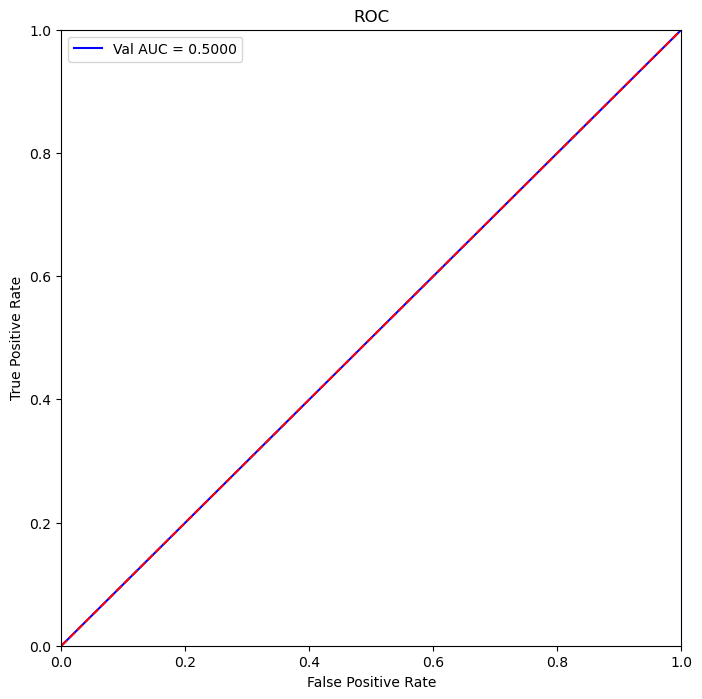

In [55]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss   
import sklearn.metrics as metrics
import matplotlib.pyplot as plt 


"""preditcion"""   
y_pred = np.round(final_model_lgb.predict(X_test)) 
# y_test = y_test.values
#计算准确率
accuracy = accuracy_score(y_test,y_pred)
print('accuracy:%3.f%%'%(accuracy*100))

"""计算roc的相关指标"""
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)    
roc_auc = metrics.auc(fpr, tpr)    
print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))    
"""画出roc曲线图"""    
plt.figure(figsize=(8, 8))    
plt.title('Validation ROC')    
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)    
plt.ylim(0,1)    
plt.xlim(0,1)    
plt.legend(loc='best')    
plt.title('ROC')    
plt.ylabel('True Positive Rate')    
plt.xlabel('False Positive Rate')    
# 画出对角线    
plt.plot([0,1],[0,1],'r--')    
plt.show()